# Objective 1: Death Prediction
*Notebook 02_O1_Classification*

## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
import joblib

## 2. 加载并预处理数据

In [3]:
df = pd.read_csv('../data/custom_covid19.csv')

# 缺失值
missing_vals = [97,98,99]
df.replace(missing_vals, np.nan, inplace=True)

# 目标变量
df['DIED'] = (df['DATE_DIED'] != '9999-99-99').astype(int)

# Top-5 强相关特征（从前面 EDA 得到）
top5 = ['PATIENT_TYPE','PNEUMONIA','INTUBED','AGE','DIABETES']

# 取子集，并编码
X = df[top5].copy()
for col in ['PATIENT_TYPE','PNEUMONIA','INTUBED','DIABETES']:
    X[col] = X[col].map({1:1,2:0})
y = df['DIED']

# 丢弃有缺失的样本
mask = X.notna().all(axis=1)
X = X[mask]; y = y[mask]

## 3. 准备训练集和验证集

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
# 打印训练集和验证集的大小
print("Train:", X_train.shape, "Validation:", X_val.shape)
# 打印训练集和验证集的死亡率
print("Death rate (train):", y_train.mean(), " (val):", y_val.mean())

Train: (14696, 5) Validation: (3675, 5)
Death rate (train): 0.3486663037561241  (val): 0.3485714285714286


## 4. 模型基线：Decision Tree & Logistic Regression

=== Decision Tree (default) ===
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2394
           1       0.56      0.67      0.61      1281

    accuracy                           0.70      3675
   macro avg       0.68      0.69      0.68      3675
weighted avg       0.72      0.70      0.71      3675



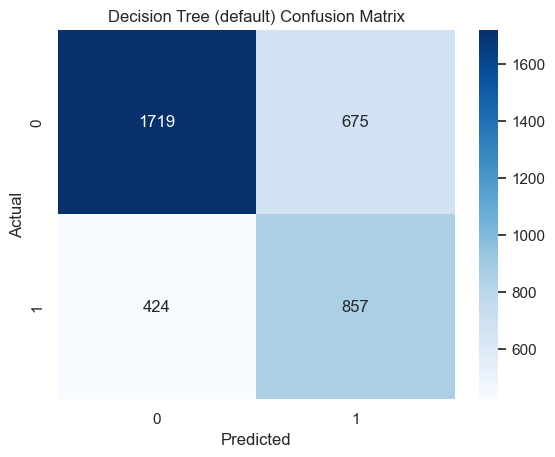

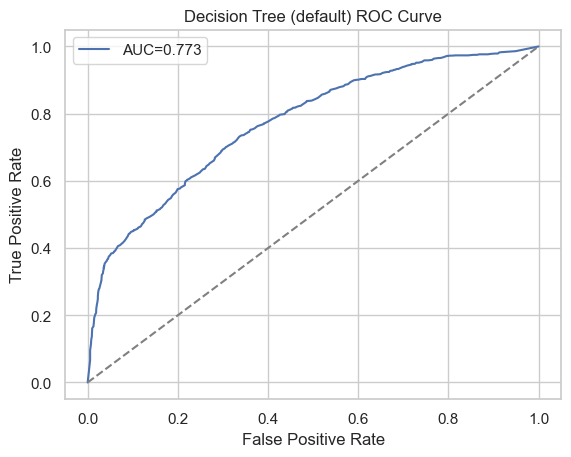

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2394
           1       0.60      0.65      0.63      1281

    accuracy                           0.73      3675
   macro avg       0.70      0.71      0.71      3675
weighted avg       0.74      0.73      0.73      3675



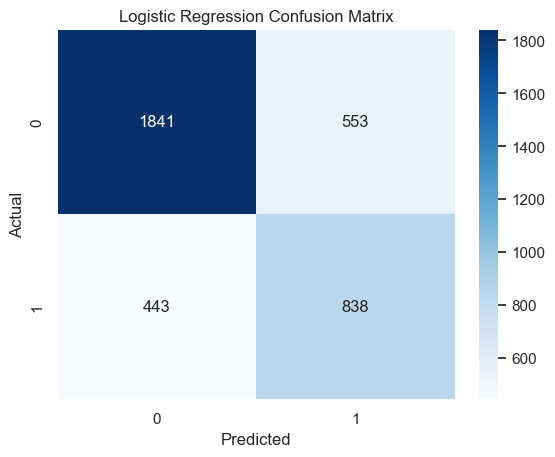

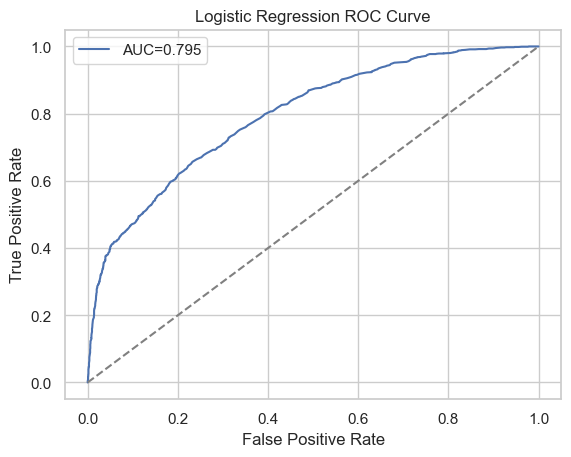

In [6]:
# 4.1 决策树（默认）
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)
y_prob_dt = dt.predict_proba(X_val)[:,1]

# 4.2 逻辑回归
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_prob_lr = lr.predict_proba(X_val)[:,1]

# 4.3 评估函数
def eval_model(name, y_true, y_pred, y_prob=None):
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f"{name} ROC Curve")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.legend(); plt.show()

# 对比评估
eval_model("Decision Tree (default)", y_val, y_pred_dt, y_prob_dt)
eval_model("Logistic Regression",  y_val, y_pred_lr, y_prob_lr)

## 5. 超参数调优 Decision Tree

Best DT params: {'ccp_alpha': 0.0001, 'max_depth': 5, 'min_samples_split': 2} Best CV F1: 0.6356694733196984
=== Decision Tree (tuned) ===
              precision    recall  f1-score   support

           0       0.82      0.72      0.76      2394
           1       0.57      0.70      0.63      1281

    accuracy                           0.71      3675
   macro avg       0.69      0.71      0.70      3675
weighted avg       0.73      0.71      0.72      3675



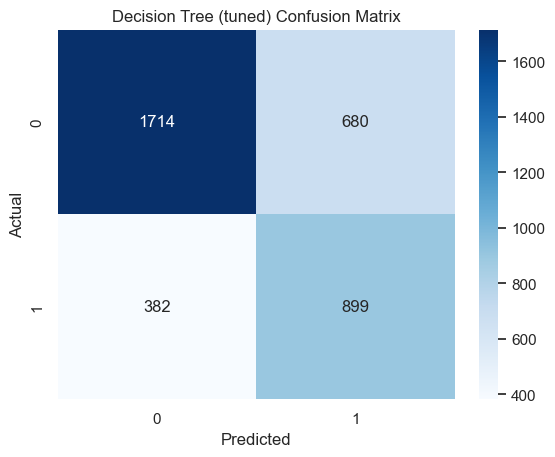

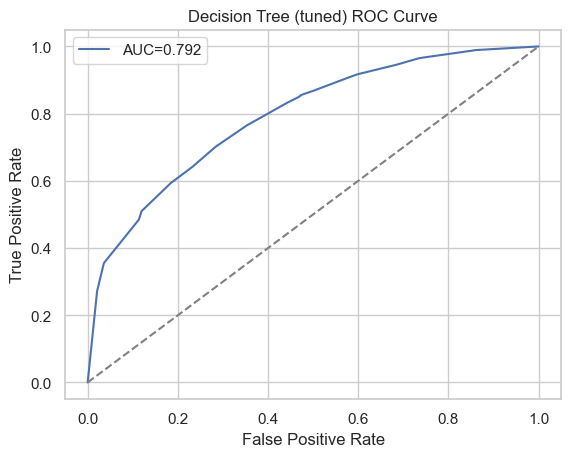

In [7]:
param_grid_dt = {
    'max_depth': [3,5,10,15],
    'min_samples_split': [2,5,10],
    'ccp_alpha': [0.0, 1e-4, 1e-3]
}
gs_dt = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid_dt, cv=5, scoring='f1'
)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
print("Best DT params:", gs_dt.best_params_, "Best CV F1:", gs_dt.best_score_)

# 重新评估最佳模型
y_pred_best = best_dt.predict(X_val)
y_prob_best = best_dt.predict_proba(X_val)[:,1]
eval_model("Decision Tree (tuned)", y_val, y_pred_best, y_prob_best)


## 6. 保存最佳模型

In [8]:
joblib.dump(best_dt, 'best_dt_model.pkl')
print("Best Decision Tree saved to best_dt_model.pkl")

Best Decision Tree saved to best_dt_model.pkl
